<a href="https://colab.research.google.com/github/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/CNN%20Image%20Classifier%20with%20MNIST%2C%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **99% Accurate Image Classification CNN with MNIST in PyTorch** 🔥

## **Part of a 3-Part Series:** Convolutional Neural Networks, Part Three

* [Link to Part One](https://github.com/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/ANN%20Image%20Classifier%20with%20MNIST.ipynb)
  * Introduction to CNNs
  * ANN Image Classification with MNIST

* [Link to Part Two](https://github.com/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/theory/deep%20learning/computer%20vision/Understanding%20CNNs.ipynb)
  * CNN Architecture Theory
    * Image Filters & Kernels
    * Convolutional Layers
    * Pooling Layers

* An introduction to CNNs, following Pierian Training's online Udemy course "PyTorch for Deep Learning with Python" bootcamp.

  * This notebook focuses on using a Convolutional Neural Network to classify handwritten digits; **Multiclass Image Classification**
  * In Part One of the series, I designed an 97% accuracy (on test set) ANN to classify the same handwritten digits that I will use here.
    * The goal is to compare the ANN to the CNN to evaluate how CNNs improve upon the methods it uses for image processing and classification.

  * **Key Metrics to compare will include:**
    * Model Accuracy
    * Number of parameters
    * Dimensionality Reduction Techniques
    * Training Time
    * Ability to capture more dimensions of data (capture quality)

#### **Results from Model Study**
| **Metric** | **ANN Model** | **CNN Model** |
| --- | --- | --- |
| No. Parameters | ~100k | ~60k |
| Training Time | ~2 Mins | ~3 Mins |
| Percentage Accuracy | ~97% | ~99% |
| Dimensionality Reduction | Not Applicable | (Max Pooling, Local Connectivity) |
| Dimension Capture | 1D | 2D |




----------

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from pathlib import Path

# machine learning packages
from sklearn.metrics import confusion_matrix

# deep learning packages
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision, torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset

# settings
# torch.set_printoptions(edgeitems=2)
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [2]:
# utils
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap='binary')
  plt.axis('off')

# **1. Download Data**

In [3]:
transform = transforms.ToTensor()

In [4]:
# error handling for downloading data to a working dir (Training Set)
try:
  train_data = datasets.MNIST(root='/content',train=True,download=True,transform=transform) # for running in colab
except Exception as e:
  print(f'Error downloading MNIST dataset to /content: {e}')
  print(f'Attempting to save to desktop instead...')

  # get path to user desktop
  desk_path = str(Path.home() / "Desktop")

  # save the dataset to the desktop
  train_data = datasets.MNIST(root=desk_path,train=True,download=True,transform=transform)
  print(f'Train Dataset saved to: {desk_path}')

In [5]:
# error handling for downloading data to a working dir (Test Set)
try:
  test_data = datasets.MNIST(root='/content',train=False,download=True,transform=transform) # for running in colab
except Exception as e:
  print(f'Error downloading MNIST dataset to /content: {e}')
  print(f'Attempting to save to desktop instead...')

  # get path to user desktop
  desk_path = str(Path.home() / "Desktop")

  # save the dataset to the desktop
  test_data = datasets.MNIST(root=desk_path,train=False,download=True,transform=transform)
  print(f'Test Dataset saved to: {desk_path}')

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: ToTensor()

## **Set Batch Sizes**

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# **2. Define a Convolutional Model**

## **Manual Convolutions**

![image description](https://raw.githubusercontent.com/aaronhowellai/machine-learning-projects/main/machine%20learning%20concepts/convolutions%2C%20convolution%20kernels%2C%20computer%20vision.png)

In [9]:
# defining convoluional layers manually: for disambiguation when building the model class later on

# 1. '1': 1 colour input channel: grayscale, normalised values
# 2. '6': 6 ouput channels: feature extraction via layers such as edge detection
# 3. '3': 3x3 kernel filter
# 4. '1': stride = 1
conv1 = nn.Conv2d(1,6,3,1) # ---> 6 convolutional kernels ---> pooling layer ---> conv2
conv2 = nn.Conv2d(6,16,3,1)

In [10]:
for i, (X_train, y_train) in enumerate(train_data):
  break

In [11]:
# reshape
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [12]:
# peform first convolution
x = F.relu(conv1(x))

In [13]:
# border is reduced by pooling layer
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# kernel size = 2x2
# stride = 2
x = F.max_pool2d(x,2,2)

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x,2,2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# floor division
11//2

5

In [21]:
# flatten the data to be passed into fully connected layers for the multiclass classification
x.view(-1,16*5*5).shape

torch.Size([1, 400])

## **Define a CNN Class**

In [22]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) # 10 output classes

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [23]:
torch.manual_seed(42)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
[print(param.numel()) for param in model.parameters()];

54
6
864
16
48000
120
10080
84
840
10


In [25]:
cnn_param_numel = sum([54,
6,
864,
16,
48000,
120,
10080,
84,
840,
10])

In [26]:
print(f'This CNN has {cnn_param_numel} parameters instead of over 100k that was used in the ANN in Part One of this CNN series.')

This CNN has 60074 parameters instead of over 100k that was used in the ANN in Part One of this CNN series.


In [27]:
# define loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=.001)

# **3. Model Training**

In [28]:
start_time = time.time()

# trackers
n = 5
epochs = n

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop, epochs
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  # train batches
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1

    # apply the model to make predictions
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1]
    # true = 1, false = 0
    batch_corr = (predicted == y_train).sum()
    trn_corr+=batch_corr

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print every 600 images
    accuracy = trn_corr.item()*100/(10*b)
    if b%600==0:
      print(f'Epoch: {i:2}  Batch: {b:4}  Loss: {loss.item():10.8f}  Accuracy: {accuracy:7.3f}%')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test batches
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):

      # apply the model
      y_val = model(X_test)

      # trackers
      predicted = torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


# how long did training take
current_time = time.time()
total = current_time - start_time
print(f'\nDuration: {total/60:.0f} minutes')

Epoch:  0  Batch:  600  Loss: 0.04055627  Accuracy:  78.417%
Epoch:  0  Batch: 1200  Loss: 0.08253475  Accuracy:  85.800%
Epoch:  0  Batch: 1800  Loss: 0.36470491  Accuracy:  88.689%
Epoch:  0  Batch: 2400  Loss: 0.01825025  Accuracy:  90.525%
Epoch:  0  Batch: 3000  Loss: 0.00806704  Accuracy:  91.650%
Epoch:  0  Batch: 3600  Loss: 0.00116694  Accuracy:  92.503%
Epoch:  0  Batch: 4200  Loss: 0.52552539  Accuracy:  93.152%
Epoch:  0  Batch: 4800  Loss: 0.03260820  Accuracy:  93.617%
Epoch:  0  Batch: 5400  Loss: 0.00746816  Accuracy:  94.028%
Epoch:  0  Batch: 6000  Loss: 0.03889676  Accuracy:  94.340%
Epoch:  1  Batch:  600  Loss: 0.03282820  Accuracy:  97.817%
Epoch:  1  Batch: 1200  Loss: 0.04554177  Accuracy:  97.867%
Epoch:  1  Batch: 1800  Loss: 0.00578480  Accuracy:  97.939%
Epoch:  1  Batch: 2400  Loss: 0.02235614  Accuracy:  97.879%
Epoch:  1  Batch: 3000  Loss: 0.21643038  Accuracy:  97.897%
Epoch:  1  Batch: 3600  Loss: 0.00501452  Accuracy:  97.906%
Epoch:  1  Batch: 4200  

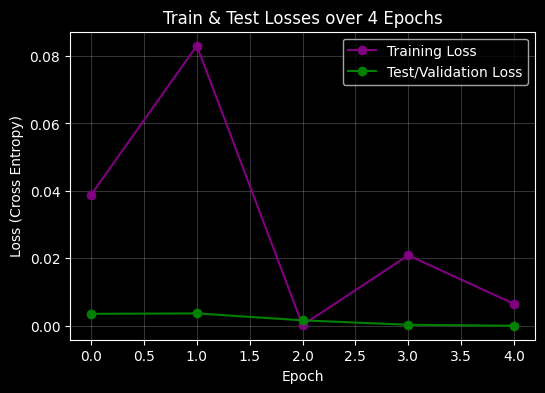

In [31]:
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
np_train_losses = [loss.detach().cpu().numpy() for loss in train_losses]
np_test_losses = [loss.detach().cpu().numpy() for loss in test_losses]

plt.plot(np_train_losses,
         marker='o',
         color='purple',
         label='Training Loss')
plt.plot(test_losses,
         marker='o',
         color='green',
         label='Test/Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Train & Test Losses over 4 Epochs')
plt.legend()
plt.grid(alpha=.2)
plt.show()

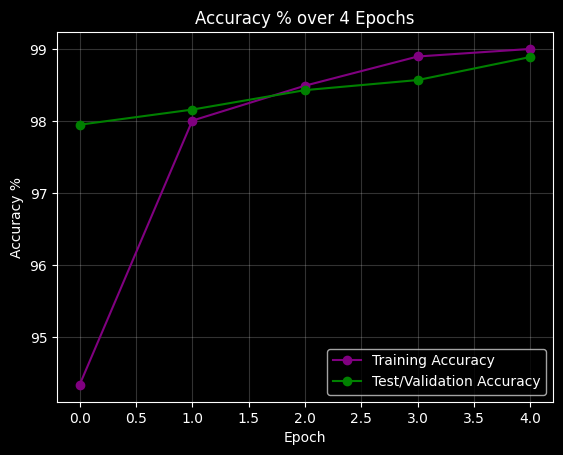

In [36]:
plt.plot([t/600 for t in train_correct],
         marker='o',
         color='purple',
         label='Training Accuracy')
plt.plot([t/100 for t in test_correct],
         marker='o',
         color='green',
         label='Test/Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy % over 4 Epochs')
plt.legend(loc='lower right')
plt.grid(alpha=.2)
plt.show()

# **4. Evaluate The Test Data**

In [37]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [38]:
with torch.no_grad():
  correct = 0
  for (X_test,y_test) in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [44]:
# total correct
t = len(test_data)
p = correct.item()

In [47]:
# calculate test accuracy
corr_perc = p/t*100
print(f'The Accuracy Percentage on the full test set is {corr_perc}% with 4 epochs at 60k parameters.')

The Accuracy Percentage on the full test set is 98.89% with 4 epochs at 60k parameters.


In [48]:
# display the confusion matrix
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    3    1    0    0    2    4    1    4    0]
 [   0 1130    2    0    0    0    1    4    0    3]
 [   0    1 1022    0    0    0    0    4    2    0]
 [   0    0    3 1007    0    7    0    2    2    2]
 [   0    0    1    0  971    0    1    0    0    5]
 [   0    0    0    1    0  879    7    0    1    5]
 [   1    1    0    0    4    2  944    0    1    0]
 [   1    0    3    0    0    0    0 1013    1    2]
 [   1    0    0    2    1    1    1    1  962    8]
 [   0    0    0    0    6    1    0    3    1  984]]


## **4.2 Run a new image through the network**


label: 9


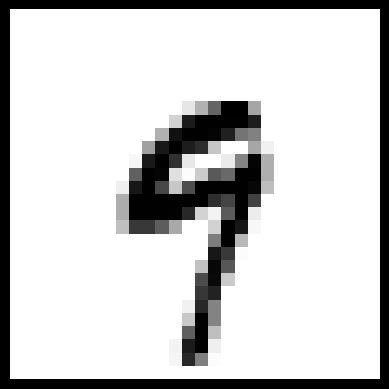

In [56]:
# new image
new_image = test_data[2019][0].reshape(28,28)
new_image_label = test_data[2019][1]
print('label:',new_image_label)
plot_digit(new_image)

### **Pass Through Model**

In [57]:
model.eval()
with torch.no_grad():
  new_prediction = model(new_image.view(1,1,28,28))

In [60]:
result = new_prediction.argmax().item()
print('The Model Prediction for the new image is: ',result)
if result == new_image_label:
  print('The result is correct!')

The Model Prediction for the new image is:  9
The result is correct!


## **Results from Model Study**
| **Metric** | **ANN Model** | **CNN Model** |
| --- | --- | --- |
| No. Parameters | ~100k | ~60k |
| Training Time | ~2 Mins | ~3 Mins |
| Percentage Accuracy | ~97% | ~99% |
| Dimensionality Reduction | Not Applicable | (Max Pooling, Local Connectivity) |
| Dimension Capture | 1D | 2D |

* [Link to Part One](https://github.com/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/ANN%20Image%20Classifier%20with%20MNIST.ipynb) for ANN Image Classification